In [1]:
import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt


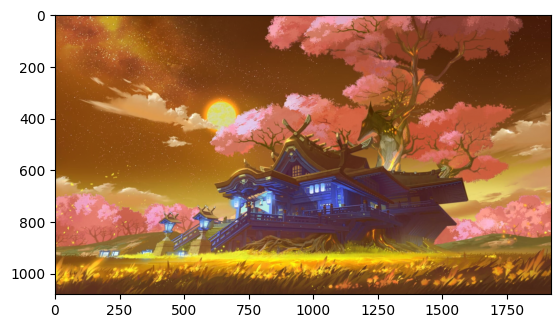

In [2]:
img=cv2.imread("D:\imageprocessing\peakpx.jpg",1)/255
plt.imshow(img)
plt.show()


In [2]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def cross_entropy(x):
    return -np.log(x)


def regularized_cross_entropy(layers, lam, x):
    loss = cross_entropy(x)
    for layer in layers:
        loss += lam * (np.linalg.norm(layer.get_weights()) ** 2)
    return loss


def leakyReLU(x, alpha=0.001):
    return np.where(x < 0, x * alpha, x)


def leakyReLU_derivative(x, alpha=0.01):
    return alpha if x < 0 else 1


In [82]:

import numpy as np

class ConvLayer:
    def __init__(self, filter_size, num_filters, activation, padding="same", stride=(1, 1)):
        self.filter_size = filter_size
        self.num_filters = num_filters
        self.activation = activation
        self.padding = padding
        self.stride = stride
        self.W = np.random.randn(filter_size, filter_size, 3, num_filters)
        self.b = np.zeros((1, 1, 1, num_filters))

    def forward_prop(self,A_prev):
	    #forward prop convolutional 3D image, RGB image - color
	    
        # Arg:
	    #    A_prev: contains the output of prev layer (m, h_prev, w_prev, c_prev)
	    #    W: filter for the convolution (kh, kw, c_prev, c_new)
	    #    b: biases (1, 1, 1, c_new)
	    #    padding: string ‘same’, or ‘valid’
	    #    stride: tuple (sh, sw)
        # Return: padded convolved images RGB np.array
        m, h_prev, w_prev, c_prev = A_prev.shape
        k_h, k_w, c_prev, c_new = self.W.shape
        s_h, s_w = self.stride
        if self.padding == 'valid':
            p_h = 0
            p_w = 0
        if self.padding == 'same':
            p_h = np.ceil(((s_h*h_prev) - s_h + k_h - h_prev) / 2)
            p_h = int(p_h)
            p_w = np.ceil(((s_w*w_prev) - s_w + k_w - w_prev) / 2)
            p_w = int(p_w)
        A_prev = np.pad(A_prev, [(0, 0), (p_h, p_h), (p_w, p_w), (0, 0)],
                        mode='constant', constant_values=0)

        out_h = int(((h_prev - k_h + (2*p_h)) / (self.stride[0])) + 1)
        out_w = int(((w_prev - k_w + (2*p_w)) / (self.stride[1])) + 1)
        output_conv = np.zeros((m, out_h, out_w, c_new))
        m_A_prev = np.arange(0, m)


        for i in range(out_h):
            for j in range(out_w):
                for f in range(c_new):
                    output_conv[m_A_prev, i, j, f] = self.activation((
                        np.sum(np.multiply(
                            A_prev[
                                m_A_prev,
                                i*(self.stride[0]):k_h+(i*(self.stride[0])),
                                j*(self.stride[1]):k_w+(j*(self.stride[1]))],
                            self.W[:, :, :, f]), axis=(1, 2, 3))) + self.b[0, 0, 0, f])
        
        
        return output_conv

    def backward_prop(self,dZ, A_prev):
	    #back prop convolutional 3D image, RGB image - color
	    # Arg:
	    #    dZ: containing the partial derivatives (m, h_new, w_new, c_new)
	    #    A_prev: contains the output of prev layer (m, h_prev, w_prev, c_prev)
	    #    W: filter for the convolution (kh, kw, c_prev, c_new)
	    #    b: biases (1, 1, 1, c_new)
	    #    padding: string ‘same’, or ‘valid’
	    #    stride: tuple (sh, sw)
	    # Returns: parcial dev prev layer (dA_prev), kernels (dW), biases (db)
        k_h, k_w, c_prev, c_new = self.W.shape
        _, h_new, w_new, c_new = dZ.shape
        m, h_x, w_x, c_prev = A_prev.shape
        s_h, s_w = self.stride
        x = A_prev
        if self.padding == 'valid':
            p_h = 0
            p_w = 0

        if self.padding == 'same':
            p_h = np.ceil(((s_h*h_x) - s_h + k_h - h_x) / 2)
            p_h = int(p_h)
            p_w = np.ceil(((s_w*w_x) - s_w + k_w - w_x) / 2)
            p_w = int(p_w)

        db = np.sum(dZ, axis=(0, 1, 2), keepdims=True)
        x_padded = np.pad(x, [(0, 0), (p_h, p_h), (p_w, p_w), (0, 0)],
                            mode='constant', constant_values=0)
        dW = np.zeros_like(self.W)
        dx = np.zeros(x_padded.shape)
        m_i = np.arange(m)
        for i in range(m):
            for h in range(h_new):
                for w in range(w_new):
                    for f in range(c_new):
                        dx[i,
                            h*(self.stride[0]):(h*(self.stride[0]))+k_h,
                            w*(self.stride[1]):(w*(self.stride[1]))+k_w,
                            :] += dZ[i, h, w, f] * self.W[:, :, :, f]
                        dW[:, :, :, f] += x_padded[i,
                                                h*(self.stride[0]):(h*(self.stride[0]))+k_h,
                                                w*(self.stride[1]):(w*(self.stride[1]))+k_w,
                                                :] * dZ[i, h, w, f]
        if self.padding == 'same':
            dx = dx[:, p_h:-p_h, p_w:-p_w, :]
        else:
            dx = dx
        return dx, dW, db

In [15]:
class MaxPool:
    def __init__(self, filter_size):
        self.filter_size = filter_size
        self.image = None

    def image_region(self, image):
        num_samples, height, width, num_filters = image.shape
        new_height = height // self.filter_size
        new_width = width // self.filter_size
        self.image = image

        for i in range(new_height):
            for j in range(new_width):
                image_patch = image[:, i * self.filter_size:(i * self.filter_size + self.filter_size), j * self.filter_size:(j * self.filter_size + self.filter_size), :]
                yield image_patch, i, j

    def forward_prop(self, image):
        num_samples, height, width, num_filters = image.shape
        new_height = height // self.filter_size
        new_width = width // self.filter_size
        output = np.zeros((num_samples, new_height, new_width, num_filters))

        for image_patch, i, j in self.image_region(image):
            output[:, i, j, :] = np.amax(image_patch, axis=(1, 2))

        return output

    def back_prop(self, dL_dout):
        dL_dmax_pool = np.zeros(self.image.shape)
        for image_patch, i, j in self.image_region(self.image):
            max_val = np.amax(image_patch, axis=(1, 2), keepdims=True)
            mask = (image_patch == max_val)
            dL_dmax_pool[:, i * self.filter_size:(i * self.filter_size + self.filter_size), j * self.filter_size:(j * self.filter_size + self.filter_size), :] = mask * dL_dout

        return dL_dmax_pool




In [89]:
class Reshape_layer:
    def __init__(self):
        self.input_shape=None
    def forward_prop(self,X):
        self.input_shape=X.shape
        n_sample,_,_,_=X.shape
        return X.reshape(-1,n_sample)
    def bacward_prop(self,X):
        return X.reshape(self.input_shape)

In [70]:
class fullycolected_layer:
    def __init__(self,w1,b1,w2,b2,w3,b3):
        self.w1=w1
        self.b1=b1
        self.w2=w2
        self.b2=b2
        self.w3=w3
        self.b3=b3
    
    def ReLU(self,Z):
        return np.maximum(Z, 0)
    def softmax(self,Z):
        A = np.exp(Z) / sum(np.exp(Z))
        return A
    def forward_prop(self, X):
        Z1 = self.w1.dot(X) + self.b1
        A1 = self.ReLU(Z1)
        Z2 = self.w2.dot(A1) + self.b2
        A2 = self.ReLU(Z2)
        Z3 = self.w3.dot(A2) + self.b3
        A3 = self.softmax(Z3)
        return Z1, A1, Z2, A2, Z3, A3
    def ReLU_deriv(self,Z):
        return Z > 0
    def one_hot(self,Y):
        one_hot_Y = np.zeros((Y.size, Y.max() + 1))
        one_hot_Y[np.arange(Y.size), Y] = 1
        one_hot_Y = one_hot_Y.T
        return one_hot_Y
    def backward_prop(self,Z1, A1, Z2, A2, Z3, A3,X, Y):
        m=Y.size
        one_hot_Y = self.one_hot(Y)
        dZ3 = A3 - one_hot_Y
        dW3 = 1 / m * dZ3.dot(A2.T)
        db3 = 1 / m * np.sum(dZ3)
        dZ2 = self.w3.T.dot(dZ3) * self.ReLU_deriv(Z2)
        dW2 = 1 / m * dZ2.dot(A1.T)
        db2 = 1 / m * np.sum(dZ2)
        dZ1 = self.w2.T.dot(dZ2) * self.ReLU_deriv(Z1)
        dW1 = 1 / m * dZ1.dot(X.T)
        db1 = 1 / m * np.sum(dZ1)
        return dW1, db1, dW2, db2, dW3, db3
    def update_params(self, dW1, db1, dW2, db2, dW3, db3, alpha):
        W1 = self.w1 - alpha * dW1
        b1 = self.b1 - alpha * db1    
        W2 = self.w2 - alpha * dW2  
        b2 = self.b2 - alpha * db2    
        W3 = self.w3 - alpha * dW3
        b3 = self.b3 - alpha * db3  
        return W1,b1,W2,b2,W3,b3
    def get_predictions(self,A2):
            return np.argmax(A2, 0)
    def get_accuracy(self,predictions, Y):
        print(predictions, Y)
        return np.sum(predictions == Y) / Y.size
    def gradient_descent(self,X, Y, epochs, lr):
        for i in range(epochs):
            Z1, A1, Z2, A2,Z3,A3 = self.forward_prop( X)
            dW1, db1, dW2, db2,dw3,db3 = self.backward_prop(Z1, A1, Z2, A2,Z3,A3, X, Y)
            W1, b1, W2, b2,W3,b3 = self.update_params(dW1, db1, dW2, db2,dw3,db3, lr)
            if i % 10 == 0:
                print("Iteration: ", i)
                predictions = self.get_predictions(A3)
                print(self.get_accuracy(predictions, Y))
        return W1, b1, W2, b2,W3,b3
    

In [90]:
def init_params():
        W1 = np.random.rand(7,1372) - 0.5
        b1 = np.random.rand(7, 1) - 0.5
        W2 = np.random.rand(7, 7) - 0.5
        b2 = np.random.rand(7, 1) - 0.5
        W3 = np.random.rand(7, 7) - 0.5
        b3 = np.random.rand(7, 1) - 0.5
        return W1, b1, W2, b2, W3, b3
W1, b1, W2, b2 , W3,b3=init_params()
full_layer=fullycolected_layer(W1,b1,W2,b2,W3,b3)
# w1,b1,w2,b2,w3,b3=full_layer.gradient_descent(out2_trans,y_train,epochs=1000,lr=0.001)

In [83]:
data=pd.read_csv('D:\MachineLearning\CNN\Data_skincancer\hmnist_28_28_RGB.csv')


In [8]:
print(data.shape)

(10015, 2353)


In [84]:
X=data.iloc[:,0:-1].values
y=data.iloc[:,-1].values

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [87]:
X_train=X_train.reshape(-1,28,28,3)
X_test=X_test.reshape(-1,28,28,3)

In [13]:
print(X_train.shape)
print(X_test.shape)

(8012, 28, 28, 3)
(2003, 28, 28, 3)


In [88]:
# conn=ConvLayer(3,7,activation=leakyReLU)
# out=conn.forward_prop(X_train)


In [75]:
print(out.shape)

(8012, 28, 28, 7)


In [80]:
# Reshape_layer=Reshape_layer()
# out2=Reshape_layer.forward_prop(out2)



In [ ]:
# # Sử dụng lớp ConvLayer
# in_channels = 3
# out_channels = 64
# kernel_size = 3
# stride = 1
# padding = 1

# conv_layer = ConvLayer(4, 7,activation=leakyReLU)
# pool=max_pool(2)
# softmax=softmax(13*13*8,10)


In [ ]:
X_train_scaled=X_train/255-0.5
X_train_scaled=X_test/255-0.5

In [ ]:
print(X_train.shape)

(8012, 28, 28, 3)


In [95]:
conv_layer=ConvLayer(3,7,activation=leakyReLU)
max_pool=MaxPool(3)
reshape=Reshape_layer()
w1,b1,w2,b2,w3,b3=init_params()
fullycolected=fullycolected_layer(w1,b1,w2,b2,w3,b3)




In [ ]:
# def cnn_forward_prop(sample,label):
#     out_p=conv_layer.forward_prop(X_train_scaled)
#     out_p=max_pool.forward_prop(out_p)
#     _,_,_,_,_,out_p=fullycolected_layer.forward_prop(out_p)
#     cross_ent_loss=-np.log(out_p[label])
#     accuracy_eval=1 if np.argmax(out_p)==label else 0
#     return out_p,cross_ent_loss,accuracy_eval


def training_cnn(image,label,learn_rate=0.005):
    out_p=conv_layer.forward_prop(X_train_scaled)
    out_p=max_pool.forward_prop(out_p)
    _,_,_,_,_,out_p=fullycolected_layer.forward_prop(out_p)
    cross_ent_loss=-np.log(out_p[label])
    gradient=np.zeros(10)
    gradient[label]=-1/out[label]
    grad_back=fullycolected_layer.back_prop(gradient,learn_rate)
    grad_back=max_pool.back_prop(grad_back)
    grad_back=ConvLayer.back_prop(grad_back,learn_rate)
    return loss,acc,

In [ ]:
# for epoch1 in range(4):
#     print('epochs %d---->' %(epoch1+1))
#     #shuffle the training data
#     shuffle_data=np.random.permutation(len(X_train))
#     X_train_scaled=X_train[shuffle_data]
#     y_train=y_train[shuffle_data]
#     # training the cnn
#     loss=0
#     num_correct=0
#     for i, (im,label) in enumerate(zip(X_train_scaled,y_train)):
#         if i %100==0:
#             print('%d steps out of 100 steps: Average Loss %.3f and accuracy: %d%%'%(i+1,loss/100,num_correct))
#             loss=0
#             num_correct=0
#         l1,accu=training_cnn(im,label)
#         loss+=l1
#         num_correct+=accu

In [92]:
max_pool=MaxPool(2)
out2=max_pool.forward_prop(out)
W1, b1, W2, b2 , W3,b3=init_params()
full_layer=fullycolected_layer(W1,b1,W2,b2,W3,b3)

    

In [96]:
# Thiết lập các tham số khởi tạo cho mạng CNN
filter_size = 3
num_filters = 7
activation = leakyReLU  # Bạn cần cung cấp hàm kích hoạt "leakyReLU"
pool_size = 3
fully_connected_weights = init_params()  # Bạn cần cung cấp hàm "init_params"

# Tạo các lớp mạng
conv_layer = ConvLayer(filter_size, num_filters, activation, padding="same", stride=(1, 1))
max_pool = MaxPool(pool_size)
reshape = Reshape_layer()
w1, b1, w2, b2, w3, b3 = fully_connected_weights
fully_connected = fullycolected_layer(w1, b1, w2, b2, w3, b3)

# Xây dựng mô hình CNN đơn giản
def simple_cnn_model(X):
    # Lớp tích chập
    conv_output = conv_layer.forward_prop(X)
    
    # Lớp tối đa hóa
    pooled_output = max_pool.forward_prop(conv_output)
    
    # Lớp biến đổi hình dạng (Flatten)
    flattened_output = reshape.forward_prop(pooled_output)
    
    # Lớp kết nối đầy đủ
    Z1, A1, Z2, A2, Z3, A3 = fully_connected.forward_prop(flattened_output)
    
    return A3

# Sử dụng mô hình để dự đoán
input_data = np.random.randn(8012, 1314)  # Thay thế bằng dữ liệu thực tế
predictions = simple_cnn_model(input_data)

ValueError: not enough values to unpack (expected 4, got 2)

In [97]:
# Lan truyền ngược cho mạng CNN đơn giản
def simple_cnn_backward(X, Y):
    # Lan truyền tiến
    conv_output = conv_layer.forward_prop(X)
    pooled_output = max_pool.forward_prop(conv_output)
    flattened_output = reshape.forward_prop(pooled_output)
    Z1, A1, Z2, A2, Z3, A3 = fully_connected.forward_prop(flattened_output)
    
    # Lan truyền ngược
    dW1, db1, dW2, db2, dW3, db3 = fully_connected.backward_prop(Z1, A1, Z2, A2, Z3, A3, flattened_output, Y)
    
    # Đảm bảo rằng bạn có hàm ReLU_deriv để sử dụng trong lan truyền ngược
    dZ3 = A3 - one_hot(Y)  # Giả sử bạn có hàm one_hot để chuyển đổi Y thành one-hot encoding
    dZ2 = fully_connected.w3.T.dot(dZ3) * fully_connected.ReLU_deriv(Z2)
    dZ1 = fully_connected.w2.T.dot(dZ2) * fully_connected.ReLU_deriv(Z1)
    
    # Cập nhật trọng số và bias
    fully_connected_weights = fully_connected.update_params(
        fully_connected.w1, fully_connected.b1, fully_connected.w2, fully_connected.b2, fully_connected.w3, fully_connected.b3,
        dW1, db1, dW2, db2, dW3, db3, alpha=0.001)  # Giả sử bạn có hàm update_params và alpha là tốc độ học
    
    return fully_connected_weights

# Sử dụng lan truyền ngược để cập nhật trọng số và bias
# Y là nhãn thực tế
# fully_connected_weights = simple_cnn_backward(input_data, Y)
